# vertical_fesed_3d


## Purpose
- Convert fesed data used in CESM into ROMS vertical grid.
- Convert pop_z -> pop_s
- Convert pop_s -> roms_s

## units
- The original units in fesedflux file are **$\mu$molFe m$^{-2}$ day$^{-1}$**, and need to convert  it into units used in model **nmolFe cm$^{-2}$ s$^{-1}$**.
 - $\mu$ -> n : $10^{3}$
 - m$^{-2}$ -> cm$^{-2}$ : $10^{-4}$
 - day$^{-1}$ -> sec$^{-1}$: $1.1574\times10^{-5}$
 - net: $1.1574\times10^{-6}$

### Load files and libraries

In [481]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [482]:
import os
import numpy as np
import numpy.ma as ma
import netCDF4
from pandas import Series, DataFrame
import pandas as pd
import pyroms
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic
import scipy

In [483]:
os.environ["PYTHONPATH"] = "/Users/misumi/python:/usr/local/lib/python2.7/site-packages"
os.environ["PYROMS"] = "$PYTHONPATH/pyroms"
os.environ["PYROMS_GRIDID_FILE"] = "/Users/misumi/work/160701_roms_work/gridid.txt"

In [484]:
grd_s = pyroms.grid.get_ROMS_grid('h025_l045_v001')
grd_z = pyroms.grid.get_ROMS_grid('h025_l045_v001_z')

Load geographical grid from file
Load geographical grid from file


In [649]:
src_nc0 = netCDF4.Dataset('/Users/misumi/work/160701_roms_work/data/fesedflux_gx1v6_etopo2v2_Dec2012.nc','r')
grd_nc0 = netCDF4.Dataset('../data/c.e12.CECO.T62_g16.INX.013.pop.h.0110-01.nc','r')
grd_nc1 = netCDF4.Dataset('../grids/h025_l045_v001.grd.160705.nc','r')
dst_nc0 = netCDF4.Dataset('../data/h025_l045_v001.fesed.161003.nc','a')
dst_nc1 = netCDF4.Dataset('../data/h025_l045_v001.dz.160705.nc','a')

In [486]:
fact = 1.1574e-6
fesed_pop_z = src_nc0.variables['FESEDFLUXIN'][:] * fact

In [487]:
pop_nz, pop_ny, pop_nx = fesed_pop_z.shape
roms_nz = grd_s.vgrid.N
roms_ny, roms_nx, = grd_s.hgrid.mask.shape

In [488]:
lat_roms = grd_s.hgrid.lat_rho
lon_roms = grd_s.hgrid.lon_rho

### Check u- and t-points in POP

In [489]:
tlat = grd_nc0.variables['TLAT'][:]
tlon = grd_nc0.variables['TLONG'][:]

ulat = grd_nc0.variables['ULAT'][:]
ulon = grd_nc0.variables['ULONG'][:]

print tlon[0,0:10]
print ulon[0,0:10]

print tlat[0:10,0]
print ulat[0:10,0]

[ 320.56250892  321.68750895  322.81250898  323.93750901  325.06250905
  326.18750908  327.31250911  328.43750914  329.56250917  330.6875092 ]
[ 321.12500894  322.25000897  323.375009    324.50000903  325.62500906
  326.75000909  327.87500912  329.00000916  330.12500919  331.25000922]
[-79.22052261 -78.68630626 -78.15208992 -77.61787338 -77.08365664
 -76.54943969 -76.01522253 -75.48100514 -74.94678751 -74.41256965]
[-78.95289509 -78.41865507 -77.88441506 -77.35017504 -76.81593503
 -76.28169501 -75.747455   -75.21321498 -74.67897497 -74.14473496]


- u-points are east and north sides

### Check uv- and rho-points in ROMS

In [490]:
print grd_s.hgrid.lon_u.shape
print grd_s.hgrid.lon_rho.shape
print grd_s.hgrid.lat_v.shape
print grd_s.hgrid.lat_rho.shape

(322, 697)
(322, 698)
(321, 698)
(322, 698)


- U-points are less than RHO-points
- V-points are less than RHO-points

In [491]:
print grd_s.hgrid.lon_u[0,:2]
print grd_s.hgrid.lon_rho[0,:2]
print grd_s.hgrid.lon_u[0,-2:]
print grd_s.hgrid.lon_rho[0,-2:]

print grd_s.hgrid.lat_v[:2,0]
print grd_s.hgrid.lat_rho[:2,0]
print grd_s.hgrid.lat_v[-2:,0]
print grd_s.hgrid.lat_rho[-2:,0]

[ 110.    110.25]
[ 109.875  110.125]
[ 283.75  284.  ]
[ 283.875  284.125]
[-14.99994368 -14.74994362]
[-15.12504097 -14.87504019]
[ 64.75002487  65.00002464]
[ 64.87517819  65.12518   ]


- U-points are located east side of RHO-points.
- V-points are located north side of RHO-points.
- Boundary of RHO-points are
 - lat: -15.125 to 64.875
 - lon: 109.875 to 283.875


### Make a mask array for POP

In [492]:
pop_msk = grd_nc0.variables['KMT'][:]
pop_msk[pop_msk > 0 ] = 1
pop_rmsk = grd_nc0.variables['REGION_MASK'][:]
pop_msk[pop_rmsk < 2] = 0
pop_msk[pop_rmsk > 3] = 0
pop_msk[tlon < 109.875] = 0
pop_msk[tlon > 283.875] = 0
pop_msk[tlat < -15.125] = 0
pop_msk[tlat > 64.875] = 0

### Make a plot

In [493]:
val2d = fesed_pop_z[:,:,:].copy()
val2d = ma.sum(val2d,axis=0)
val2d = ma.masked_where(pop_msk==0,val2d)

In [494]:
ulon = ma.where(ma.greater_equal(ulon,min(ulon[:,0])),ulon-360,ulon)
ulon = ma.concatenate((ulon,ulon+360),1)
ulat = ma.concatenate((ulat,ulat),1)
val2d = ma.concatenate((val2d,val2d),1)

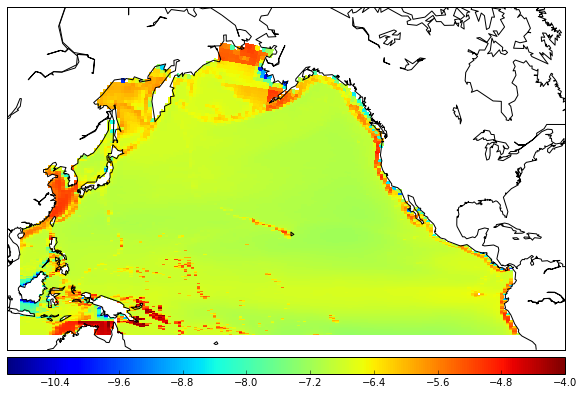

In [495]:
val2d = ma.log10(val2d)
fig0 = plt.figure(figsize=(10,10))
ax0 = fig0.add_subplot(111)
m0 = Basemap(projection='merc', lat_ts = 20, llcrnrlon = 105, \
           urcrnrlon=300, llcrnrlat=-20,urcrnrlat=70,resolution='c')
x,y = m0(ulon,ulat)
im0 = m0.pcolor(x,y,val2d[1:,1:],vmin=-11,vmax=-4)
m0.drawcoastlines()
cb0 = m0.colorbar(im0,'bottom',size='5%',pad='2%')

- Units are in nmol cm$^-2$ s$^-1$.
- Displaying in log scale.

### Analyze data

In [496]:
val2d = fesed_pop_z[:,:,:].copy()
val2d = ma.sum(val2d,axis=0)
val2d = ma.masked_where(pop_msk==0,val2d)
wgt = grd_nc0.variables['TAREA'][:]
tot = val2d.copy() * wgt

tot = ma.sum(tot)
print tot

xx = val2d.copy()
xx = ma.masked_where(xx==0,xx)
xx = xx.flatten()
xx = xx.compressed()
df = DataFrame(xx)
df.describe()

767757219739.0


,0
count,2.431400e+04
mean,7.872421e-07
std,6.067377e-06
min,5.533819e-12
25%,1.009737e-07
50%,1.349942e-07
75%,1.703923e-07
max,2.471049e-04


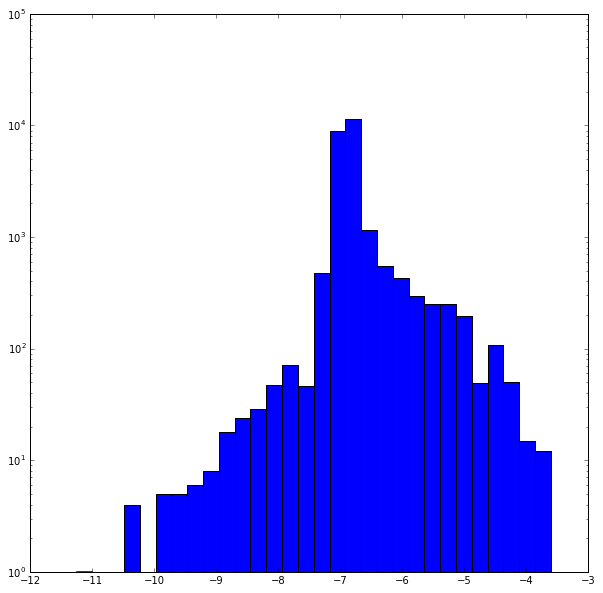

In [497]:
fig0 = plt.figure(figsize=(10,10))
ax0 = fig0.add_subplot(111)
ax0.hist(ma.log10(xx),30,histtype='bar')
ax0.set_yscale('log')

### Summing up bottom data to add remapped data

In [498]:
q = np.zeros(fesed_pop_z.shape)
kmt = grd_nc0.variables['KMT'][:]
kmt = kmt-1

del x
for k in range(pop_nz):
    x = fesed_pop_z[k,:,:].copy()
    x[kmt>k] = 0.0
    q[k,:,:] = x[:,:]

p = np.sum(q,axis=0)

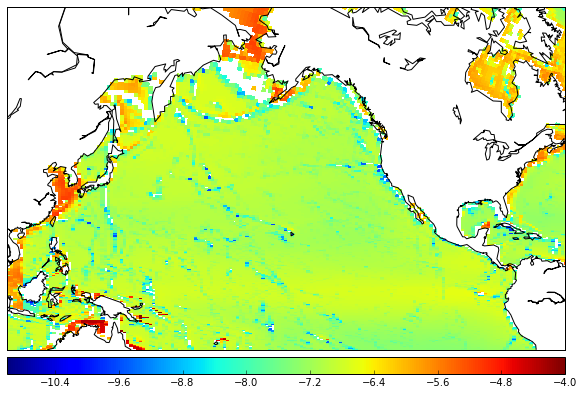

In [499]:
p2 = ma.concatenate((p,p),1)

fig4 = plt.figure(figsize=(10,10))
ax0 = fig4.add_subplot(111)
m0 = Basemap(projection='merc', lat_ts = 20, llcrnrlon = 105, \
           urcrnrlon=300, llcrnrlat=-20,urcrnrlat=70,resolution='c')
x,y = m0(ulon,ulat)

im0 = m0.pcolor(x,y,ma.log10(p2),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb0 = m0.colorbar(im0,'bottom',size='5%',pad='2%')

### Remapping

In [500]:
rmp_file = '../data/remap_gx1v6_to_h025_l045_v001_t_bilin.nc'
val_roms_z = pyroms.remapping.remap(fesed_pop_z[:,1:,1:].copy(),rmp_file,spval=np.nan)
val_roms_a = pyroms.remapping.remap(p[1:,1:],rmp_file,spval=np.nan)
val_roms_z = ma.masked_invalid(val_roms_z)
val_roms_a = ma.masked_invalid(val_roms_a)
val_roms_s = ma.zeros((roms_nz, roms_ny,roms_nx))

In [501]:
for k in range(pop_nz):
    a = val_roms_z[k,:,:].copy()
    a = a.flatten()
    lat_roms_1d = lat_roms.flatten()
    lon_roms_1d = lon_roms.flatten()
    lat_roms_1d = ma.masked_where(a.mask,lat_roms_1d)
    lon_roms_1d = ma.masked_where(a.mask,lon_roms_1d)
    a = a.compressed()
    lat_roms_1d = lat_roms_1d.compressed()
    lon_roms_1d = lon_roms_1d.compressed()
    pts = np.zeros((lat_roms_1d.size,2))
    pts[:,0] = lon_roms_1d[:]
    pts[:,1] = lat_roms_1d[:]
    fesed_roms_z[k,:,:] = scipy.interpolate.griddata(pts,a,(lon_roms,lat_roms),method='nearest')
val_roms_z = val_roms_z[::-1,:,:]
val_roms_s = pyroms.remapping.z2roms(val_roms_z[:,:,:],grd_z,grd_s)

### Check remapped data

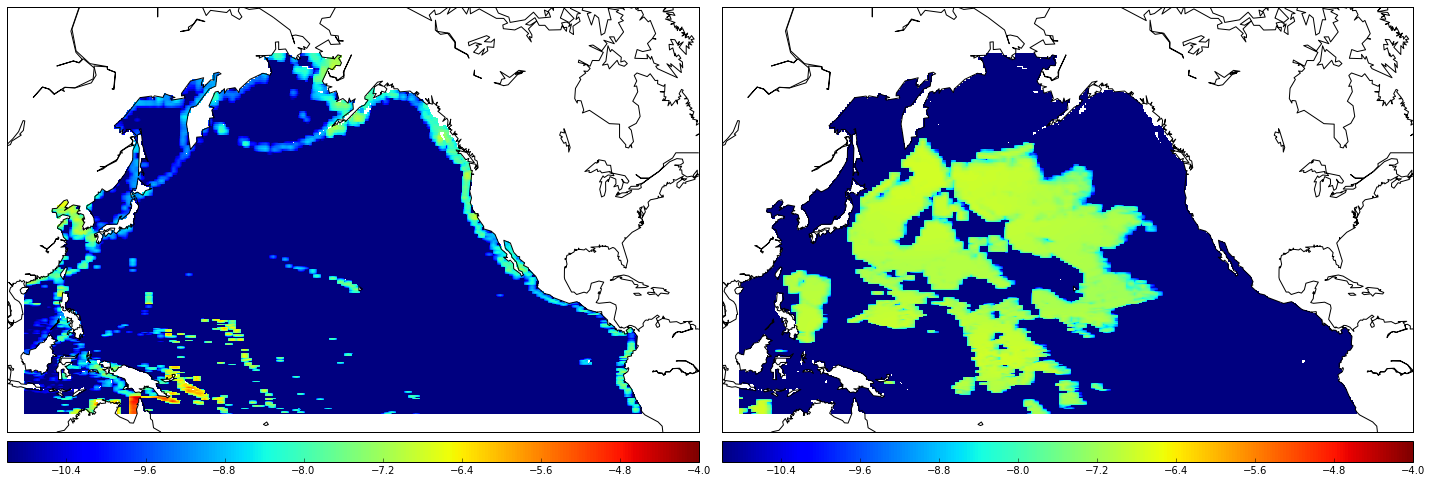

In [502]:
val3d = val_roms_z[:,:,:].copy()
val3d[val3d < 1.e-15] = 1.e-15

fig1 = plt.figure(figsize=(20,15))

ax0 = fig1.add_subplot(221)
m0 = Basemap(projection='merc', lat_ts = 20, llcrnrlon = 105, \
           urcrnrlon=300, llcrnrlat=-20,urcrnrlat=70,resolution='c')
x,y = m0(grd_z.hgrid.lon_u[1:,:],grd_z.hgrid.lat_v[:,1:])
im0 = m0.pcolor(x,y,ma.log10(val3d[-1,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb0 = m0.colorbar(im0,'bottom',size='5%',pad='2%')

ax1 = fig1.add_subplot(222)
im1 = m0.pcolor(x,y,ma.log10(val3d[0,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb1 = m0.colorbar(im1,'bottom',size='5%',pad='2%')

fig1.tight_layout()

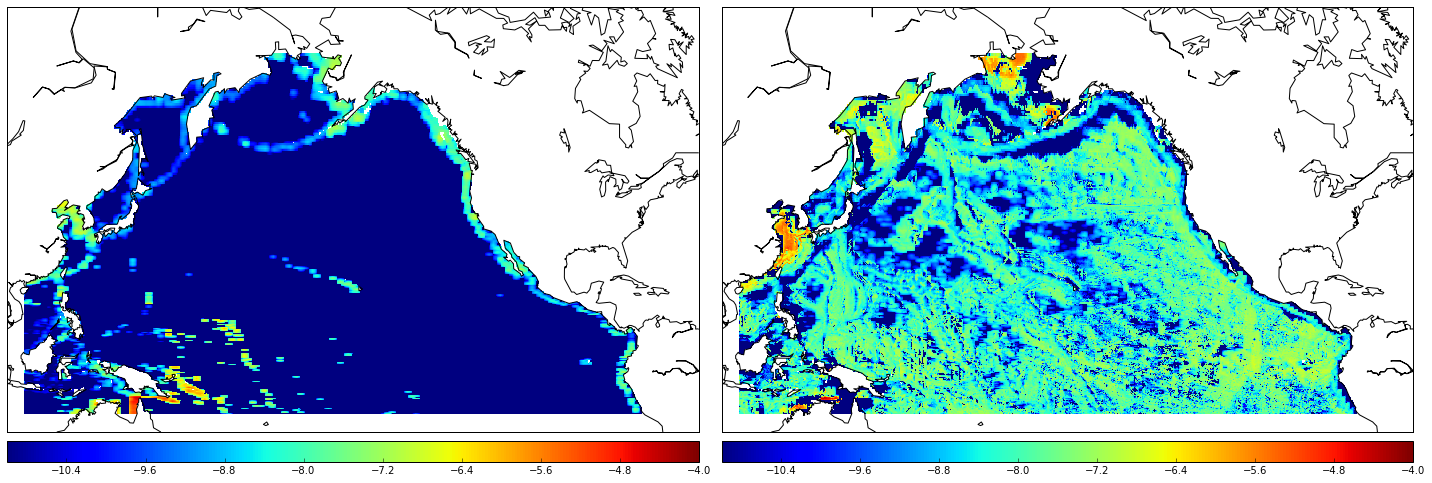

In [503]:
del val3d
val3d = fesed_roms_s[:,:,:].copy()
val3d[val3d < 1.e-15] = 1.e-15

fig2 = plt.figure(figsize=(20,15))

ax0 = fig2.add_subplot(221)
m0 = Basemap(projection='merc', lat_ts = 20, llcrnrlon = 105, \
           urcrnrlon=300, llcrnrlat=-20,urcrnrlat=70,resolution='c')
x,y = m0(grd_z.hgrid.lon_u[1:,:],grd_z.hgrid.lat_v[:,1:])
im0 = m0.pcolor(x,y,ma.log10(val3d[-1,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb0 = m0.colorbar(im0,'bottom',size='5%',pad='2%')

ax1 = fig2.add_subplot(222)
im1 = m0.pcolor(x,y,ma.log10(val3d[0,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb1 = m0.colorbar(im1,'bottom',size='5%',pad='2%')

fig2.tight_layout()

### Adding the bottom data
- The lower values in shelf breaks (Right Panel) are likely due to inconsistency between model and actual topography.
- The lower values are vanished when integrated the data vertically (Lower Panel).

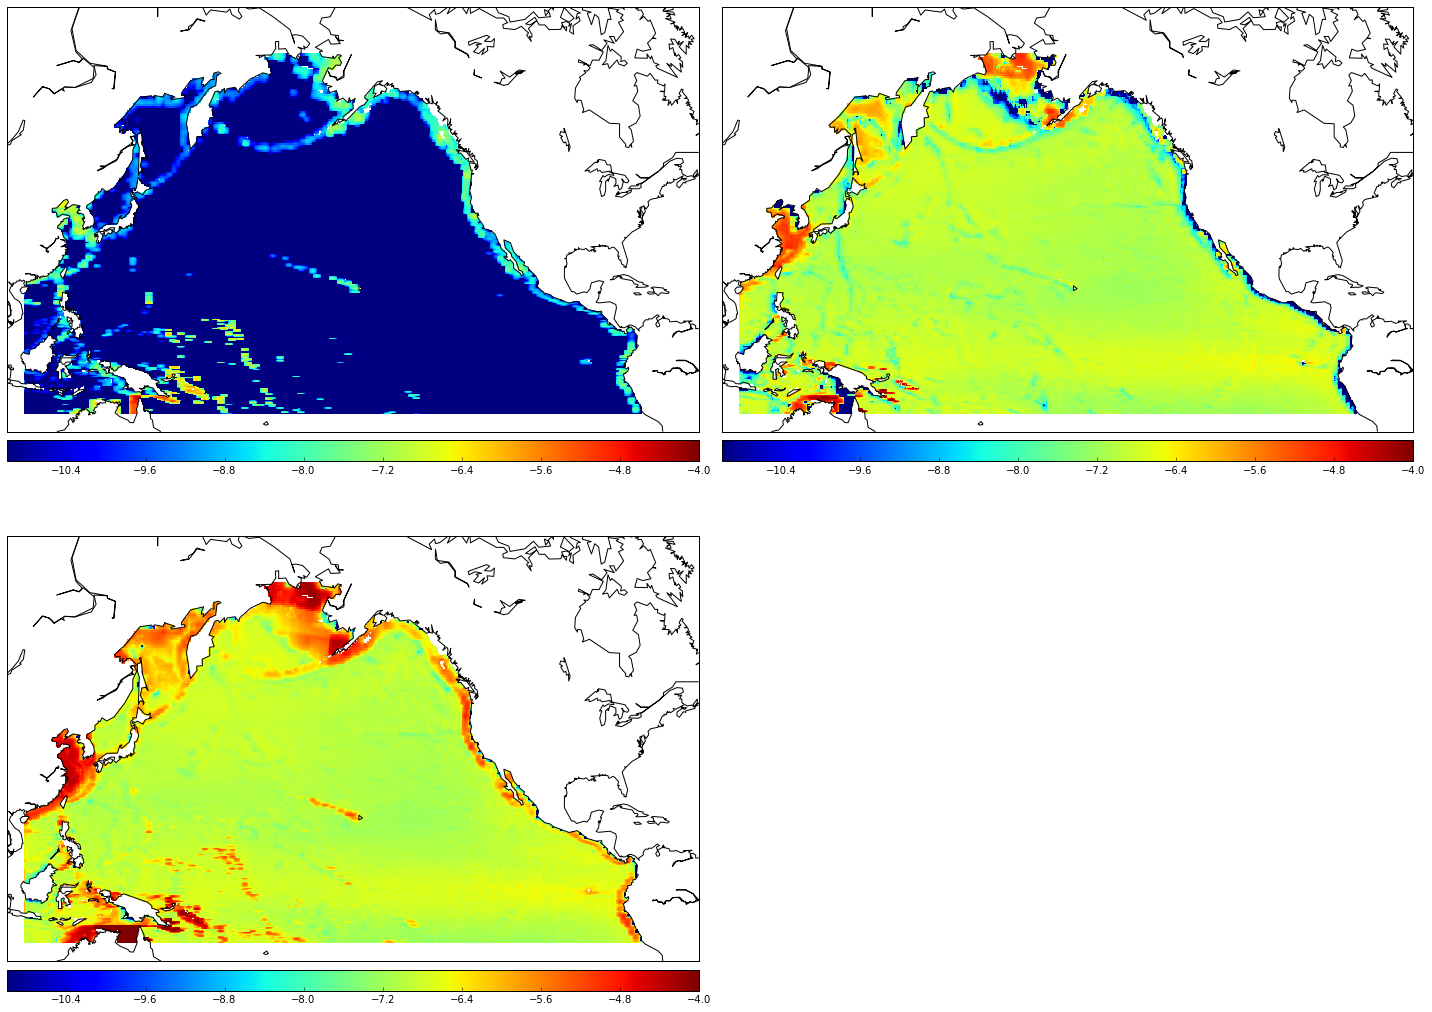

In [504]:
val_roms_s[0,:,:] = val_roms_s[0,:,:] + val_roms_a[:,:]

del val3d
val3d = val_roms_s[:,:,:].copy()
val3d[val3d < 1.e-15] = 1.e-15
val2d = ma.sum(val3d,axis=0)

fig2 = plt.figure(figsize=(20,15))

ax0 = fig2.add_subplot(221)
m0 = Basemap(projection='merc', lat_ts = 20, llcrnrlon = 105, \
           urcrnrlon=300, llcrnrlat=-20,urcrnrlat=70,resolution='c')
x,y = m0(grd_z.hgrid.lon_u[1:,:],grd_z.hgrid.lat_v[:,1:])
im0 = m0.pcolor(x,y,ma.log10(val3d[-1,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb0 = m0.colorbar(im0,'bottom',size='5%',pad='2%')

ax1 = fig2.add_subplot(222)
im1 = m0.pcolor(x,y,ma.log10(val3d[0,1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb1 = m0.colorbar(im1,'bottom',size='5%',pad='2%')

ax2 = fig2.add_subplot(223)
im2 = m0.pcolor(x,y,ma.log10(val2d[1:-1,1:-1]),vmin=-11,vmax=-4)
m0.drawcoastlines()
cb2 = m0.colorbar(im1,'bottom',size='5%',pad='2%')

fig2.tight_layout()

### Investigate areal extent consistency

In [628]:
R_e = 6371
L_e = 2.0 * np.pi * R_e
O_e = L_e / 360.0
dd = 0.25

lat_rho = grd_nc1.variables['lat_rho'][:]

dx = O_e * 0.25 * np.cos(np.radians(lat_rho[:,0]))
dy = O_e * 0.25

S = np.zeros(lat_rho.shape)

S = S.T + dx * dy
S = S.T
S = S * 1.e4 * 1.e6 # convert to cm2
wgt_roms = S.copy()
S = ma.masked_where(grd_s.hgrid.mask_rho==0,wgt_roms)
print ma.sum(S)

1.09287023294e+18


In [629]:
del S
wgt_pop = grd_nc0.variables['TAREA'][:]
S = ma.masked_where(pop_msk==0,wgt_pop)
print ma.sum(S)

1.10165107225e+18


In [643]:
val2d = fesed_pop_z[:,:,:].copy()
val2d = ma.sum(val2d,axis=0)
val2d = ma.masked_where(pop_msk==0,val2d)
tot = val2d.copy() * wgt_pop

tot = ma.sum(tot)
print '%.2e' % (tot)

xx = val2d.copy()
xx = ma.masked_where(xx==0,xx)
xx = xx.flatten()
xx = xx.compressed()
df = DataFrame(xx)
df.describe()

7.68e+11


,0
count,2.431400e+04
mean,7.872421e-07
std,6.067377e-06
min,5.533819e-12
25%,1.009737e-07
50%,1.349942e-07
75%,1.703923e-07
max,2.471049e-04


In [644]:
del val2d
val2d = val_roms_s.copy()
val2d = ma.sum(val2d,axis=0)
val2d = ma.masked_where(grd_s.hgrid.mask_rho == 0, val2d)
tot = val2d.copy() * wgt_roms
tot = ma.sum(tot)
print '%.2e' % (tot)

xx = val2d.copy()
xx = ma.masked_where(xx==0,xx)
xx = xx.flatten()
xx = xx.compressed()
df = DataFrame(xx)
df.describe()

2.37e+12


,0
count,1.588840e+05
mean,2.135048e-06
std,2.273888e-05
min,2.331800e-12
25%,9.642980e-08
50%,1.279025e-07
75%,1.846112e-07
max,1.457586e-03


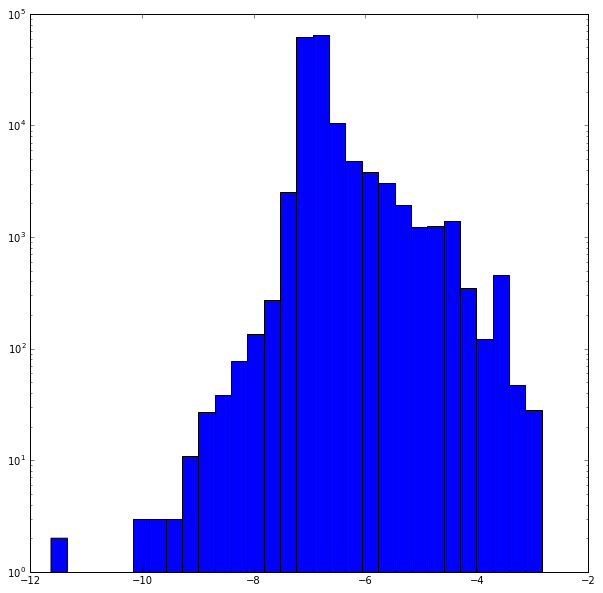

In [650]:
fig3 = plt.figure(figsize=(10,10))
ax0 = fig3.add_subplot(111)

ax0.hist(ma.log10(xx),30,histtype='bar')
ax0.set_yscale('log')

In [651]:
dst_nc0.variables['fesed'][:] = val_roms_s[:]

### Check integrated value
The transfromation functions (https://www.myroms.org/wiki/Vertical_S-coordinate) are
$$z(x,y,\sigma) = h(x,y) S(x,y,\sigma) = h(x,y)\left[ \frac{h_c \sigma+h(x,y)C(\sigma)}{h_c+h(x,y)} \right]$$
$$dz = d\sigma h(x,y) \left[ \frac{h_c}{h_c + h(x,y)} \right],$$
where
$$C(\sigma) = \frac{1 - \cosh(\theta_s \sigma)}{\cosh(\theta_s)-1}, \hspace{10mm} \text{for } \theta_s > 0$$
and
$$C(\sigma) = \frac{\exp(\theta_b C(\sigma)) - 1}{1 - \exp(-\theta_b)}, \hspace{10mm} \text{for } \theta_b > 0.$$

The parameter values used in my model are
- $h_c = 400.0$
- $\theta_s = 8.0$
- $\theta_b = 0.125$




In [94]:
h_c = 400.0
t_s = 8.0
t_b = 0.125

In [100]:
h = grd_nc1.variables['h'][:]
z = ma.zeros((roms_nz+1,roms_ny,roms_nx))
k = 0
for s in np.linspace(-1.0,0.0,num=46):
    C = (1.0- np.cosh(t_s * s)) / (np.cosh(t_s) - 1.0)
    C = (np.exp(t_b * C)-1.0) / (1.0-np.exp(-t_b))
    z[k,:,:] = h * ((h_c * s + h*C)/(h_c + h))
    k = k + 1

In [124]:
zo = z[:,:,:].copy()
zs = np.roll(z[:,:,:],-1,axis=0).copy()

dz = zs[0:-1,:,:]-zo[0:-1,:,:]

print dz[:,120,120]

[ 682.44074242  583.28434784  497.21815868  422.9731892   359.24995898
  304.78602815  258.39713017  218.9995153   185.61938485  157.39380535
  133.5662844   113.47925244   96.56498875   82.33601305   70.37559375
   60.32876452   51.89406344   44.81609054   38.87890352   33.9002242
   29.72640116   26.22806055   23.29637184   20.839856     18.78166703
   17.05728345   15.61255266   14.40203727   13.38761907   12.5373218
   11.82431939   11.22610102   10.72376835   10.30144411    9.94577416
    9.64550796    9.39114464    9.17463373    8.98912129    8.82873362
    8.68839174    8.5636509     8.45056004    8.34553682    8.24525423]


In [130]:
dst_nc1.variables['dz'][:] = dz[:]